In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    AccidentalBequestWarmGlowConsumerType,
    init_lifecycle,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
Agent = AccidentalBequestWarmGlowConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
Agent.cycles = 1

In [4]:
start_time = time()
Agent.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
Agent.unpack("cFunc")

Solving a lifecycle consumer took 0.1859288215637207 seconds.


Consumption functions


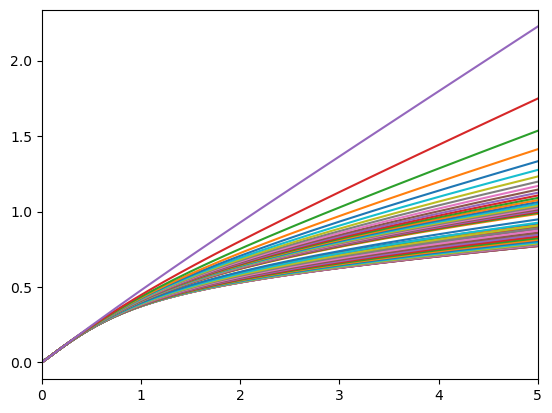

In [5]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(Agent.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
Agent.AgentCount = 500
Agent.T_sim = 200

# Set up the variables we want to keep track of.
Agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
Agent.initialize_sim()
Agent.simulate()

{'aNrm': array([[  0.69642503,   1.32334867,   0.76234864, ...,   2.0828265 ,
           3.11359683,   0.64980229],
        [  0.97443163,   1.66809376,   1.22849259, ...,   2.2305864 ,
           2.27396457,   0.99051163],
        [  1.46977623,   2.92443913,   1.5820619 , ...,   2.06626677,
           3.4228249 ,   2.08982555],
        ...,
        [  4.87631562, 115.11779604,   5.38426412, ...,   8.508619  ,
          15.16849623,  20.93138197],
        [  5.88239528, 108.41655409,   6.91896991, ...,   6.57798922,
          16.41857212,  27.37313372],
        [  8.82233921, 101.76961011,   8.01586465, ...,   6.20764156,
          13.37151765,  24.00169843]]),
 'cNrm': array([[ 0.42639485,  0.58351205,  0.44757497, ...,  0.70554089,
          0.8262221 ,  0.41052456],
        [ 0.50345982,  0.63890362,  0.56032089, ...,  0.71801658,
          0.72360447,  0.50741985],
        [ 0.60305683,  0.79179424,  0.62165893, ...,  0.69246286,
          0.84030885,  0.69544854],
        ...,
  

In [7]:
raw_data = {
    "Age": Agent.history["t_age"].flatten() + birth_age - 1,
    "pIncome": Agent.history["pLvl"].flatten(),
    "nrmM": Agent.history["mNrm"].flatten(),
    "nrmC": Agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

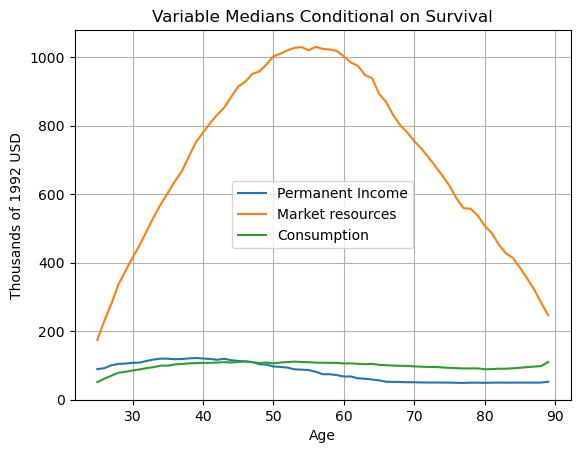

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()